# Neural Dependency Parsing Using Arc Eager
Raazia Tariq (2043894), Maliha Khan (2043885)

## Introduction

Transition-based dependency parsing is one of the most popular methods for implementing a dependency parsers.  We use here the **arc-eager** model, that has been presented in class. We augment the parser with neural machinery for contextual word embeddings and for choosing the most appropriate parser actions.

We implement the following features:
* LSTM representation for stack tokens
* BERT transformer from Hugging Face
* MLP for next transition classification, based on two top-most stack tokens and first token in the buffer
* training under static oracle

The reference paper is:
> Yoav Goldberg and Joakim Nivre. 2012. A Dynamic Oracle for Arc-Eager Dependency Parsing. In Proceedings of COLING 2012, pages 959–976, Mumbai, India. The COLING 2012 Organizing Committee.

> Kiperwasser and Goldberg, Simple and Accurate Dependency Parsing Using Bidirectional LSTM Feature Representations
*Transactions of the Association for Computational Linguistics*, Volume 4, 2016.

In [1]:
#@title Necessary Libraries
!pip install datasets  # huggingface library with dataset
!pip install conllu
!pip install evaluate
!pip install transformers
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [2]:
#@title Necessary Imports
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset

from transformers import BertModel, AutoTokenizer
from functools import partial
from datasets import load_dataset, Dataset

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Arc-Eager

Recall that a **configuration** of the arc-eager parser is a triple of the form $( \sigma, \beta, A)$
where:

* $\sigma$ is the stack;
* $\beta$ is the input buffer;
* $A$ is a set of arcs constructed so far.

We write $\sigma_i$, $i \geq 1$, for the $i$-th token in the stack; we also write $\beta_i$, $i \geq 1$, for the $i$-th token in the buffer.

The parser can perform four types of **actions** (transitions):

* **shift**, which removes $\beta_1$ from the buffer and pushes it into the stack;
* **left-arc**, which creates the arc $(\sigma_1 \rightarrow \sigma_2)$, and removes $\sigma_2$ from the stack;
* **right-arc**, which creates the arc $(\sigma_2 \rightarrow \sigma_1)$
* **reduce**, which removes $\sigma_1$ from the stack.

Let $w = w_0 w_1 \cdots w_{n}$ be the input sentence, with $w_0$ the special symbol `<ROOT>`.
Stack and buffer are implemented as lists of integers, where `j` represents word $w_j$.  Top-most stack token is at the right-end of the list; first buffer token is at the left-end of the list.
Set $A$ is implemented as an array `arcs` of size $n+1$ such that if arc $(w_i \rightarrow w_j)$ is in $A$ then `arcs[j]=i`, and if $w_j$ is still missing its head node in the tree under construction, then `arcs[j]=-1`. We always have `arcs[0]=-1`.  We use this representation also for complete dependency trees.


In [3]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # one shift move to initialize the stack
    self.shift()

  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def left_arc(self):
    o1 = self.stack.pop()
    o2 = self.buffer[0]
    self.arcs[o1] = o2


  def right_arc(self):
    o1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    o2 = self.stack.pop()
    self.arcs[o1] = o2
    self.stack.append(o2)
    self.stack.append(o1)


  def reduce(self):
    o1 = self.stack.pop()

  def is_tree_final(self):
    return len(self.stack) == 1 and len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

## Oracle

Recall that a **static oracle** maps parser configurations $c$ into  actions, and it does so by looking into the gold (reference) tree for the sentence at hand.  If $c$ does not contain any mistake, then the action provided by the oracle for $c$ is guaranted to be correct.  Furthermore, in cases where there is more than one correct action for $c$, the oracle always chooses a single action, called the **canonical** action.

We use here the static oracle for the arc-eager parser that has been presented in class.  The oracle is based on the following conditions:
* set $A$ in configuration $c$ does not contain any wrong dependency
* **left-arc** has precedence over other actions, and can be done only if it constructs a gold dependency
* **right-arc** can be done only if it constructs a gold dependency
* **reduce** can be done only if $\sigma_1$ has already collected all of its dependents and has head in stack
* **shift** transition has lowest precedence, and can be done if the buffer is not empty, and there's no possibilty of **left-arc**, **right-arc** or **reduce** actions

In [4]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    o1 = self.parser.stack[len(self.parser.stack)-1]
    o2 = self.parser.buffer[0]

    if self.gold[o1] == o2 and self.parser.arcs[o1] != self.gold[o1] and o1 != -1:
      return True

    return False


  def is_right_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    o1 = self.parser.stack[len(self.parser.stack)-1]
    o2 = self.parser.buffer[0]

    if self.gold[o2] != o1:
      return False

    return True

  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False

    return True

  def is_reduce_gold(self):
    if len(self.parser.stack) < 2:
      return False
    o1 = self.parser.stack[-1]
    if self.has_head(o1) and self.has_all_children(o1):
      return True
    return False

  def has_head(self, node):
    if self.parser.arcs[node] != -1:
      return True
    else:
      return False

  def has_all_children(self, node):
    i = 0
    for arc in self.gold:
      if arc == node:
        if self.parser.arcs[i] != node:
          return False
      i+=1
    return True

Let us come back to our example.

In [ ]:
sentence = ["<ROOT>", "Book", "the", "flight", "through", "hoston"]
gold = [-1, 0, 3, 1, 5, 3]

# ['About', 'ANSI', 'SQL', 'query', 'mode']
# sentence = ["<ROOT>", 'About', 'ANSI', 'SQL', 'query', 'mode']
# gold = [-1, 5, 5, 2, 5, 0]

parser = ArcEager(sentence)
oracle = Oracle(parser, gold)

parser.print_configuration()

['<ROOT>'] ['Book', 'the', 'flight', 'through', 'hoston']
[-1, -1, -1, -1, -1, -1]


We do a simple manual test on the oracle

In [ ]:
print("Left Arc: ", oracle.is_left_arc_gold())
print("Right Arc: ", oracle.is_right_arc_gold())
print("Shift: ",  oracle.is_reduce_gold())
print("Reduce: ", oracle.is_shift_gold())

Left Arc:  False
Right Arc:  True
Shift:  False
Reduce:  False


Then we let the oracle run and we test that it produces the correct gold tree

In [ ]:
while not parser.is_tree_final():
  if oracle.is_left_arc_gold():
    parser.left_arc()
  elif oracle.is_right_arc_gold():
    parser.right_arc()
  elif oracle.is_reduce_gold():
    parser.reduce()
  elif oracle.is_shift_gold():
    parser.shift()


print('Parsed:', parser.arcs)
print('Gold:',gold)

Parsed: [-1, 0, 3, 1, 5, 3]
Gold: [-1, 0, 3, 1, 5, 3]


## Dataset

We use the huggingface [datasets](https://github.com/huggingface/datasets) library, and train on the English [treebank](https://huggingface.co/datasets/viewer/?dataset=universal_dependencies) from the Universal Dependency project.

Variable `dataset` below is an array recording the training set.
Each element `dataset[i]` is a dictionary, recording key/annotation pairs for the $(i+1)$-th sentence. Possible annotations are tokens, lemmas, PoS tags, dependency tree, etc., which can be accessed using the appropriate key.


In [5]:
dataset = load_dataset('universal_dependencies', 'en_lines', split="train")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


## Create training data and iterable dataloaders



Recall that to run the arc-eager parser we need a **classifier** that looks at some of the content of the current parser configuration and selects an approapriate action.  In order to train the classifier, we need to convert the gold trees in our treebank into several pairs of the form configuration/gold action.  This is what we do in this section.

First of all, we need to preprocess the training set. We remove non-projective trees.  We also create a dictionary of word/index pairs, to be used later when creating word embeddings.  Words that have less than three occurrences are not encoded and will later be mapped to special token `<unk>`.

In [6]:
# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

Number of samples:
Train:	 2922
Dev:	 1032
Test:	 1035


Text(0.5, 1.0, 'Sentence lenght distribution in Test dataset')

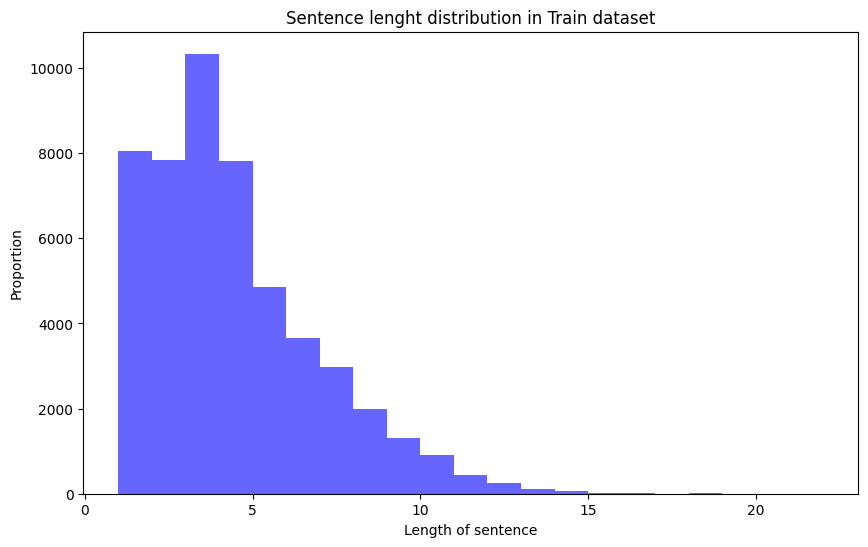

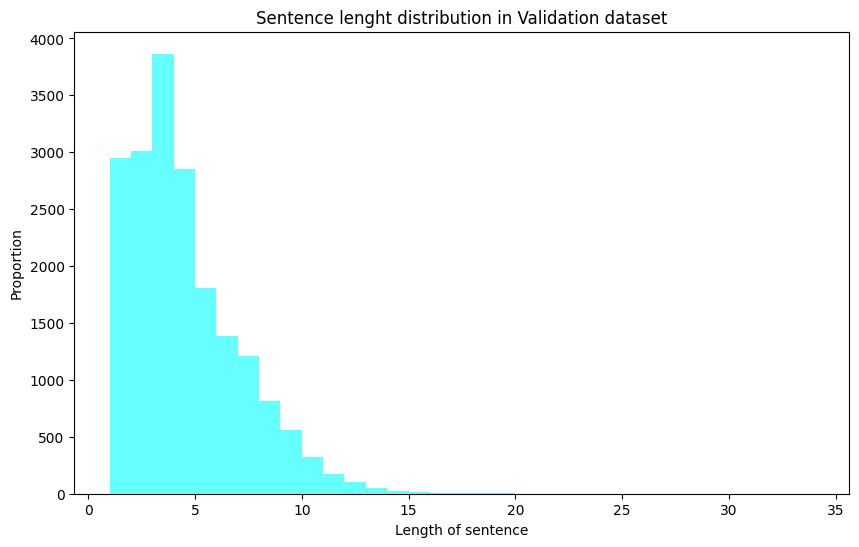

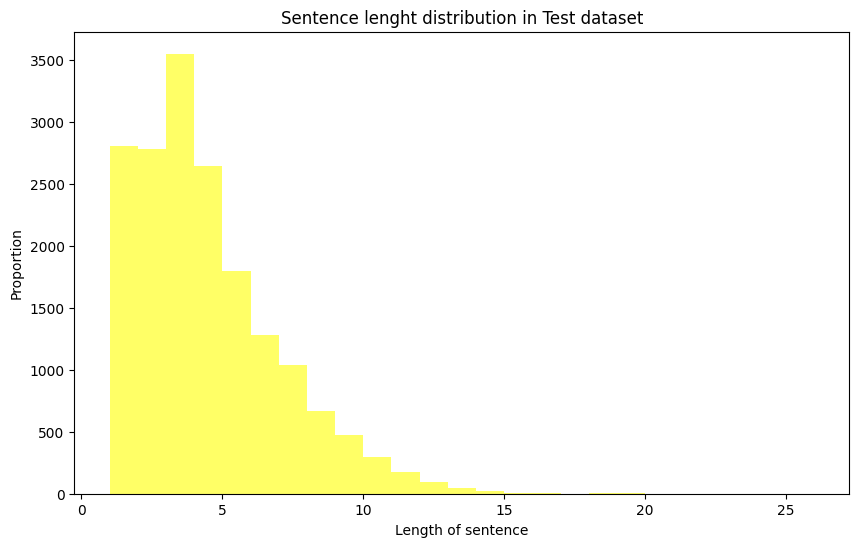

In [7]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test")

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

print("Number of samples:")
print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

sent_len_train =[]
for elements in train_dataset:
    for i, sentence in enumerate(elements["tokens"]):
      sent_len_train.append(len(sentence))
plt.figure(figsize=(10, 6))
plt.hist(sent_len_train, bins=range(min(sent_len_train), max(sent_len_train) + 1, 1),
              alpha=0.6, color="blue")
plt.xlabel("Length of sentence")
plt.ylabel("Proportion")
plt.title("Sentence lenght distribution in Train dataset")


sent_len_dev =[]
for elements in dev_dataset:
    for i, sentence in enumerate(elements["tokens"]):
      sent_len_dev.append(len(sentence))
plt.figure(figsize=(10, 6))
plt.hist(sent_len_dev, bins=range(min(sent_len_dev), max(sent_len_dev) + 1, 1),
              alpha=0.6, color="cyan")
plt.xlabel("Length of sentence")
plt.ylabel("Proportion")
plt.title("Sentence lenght distribution in Validation dataset")


sent_len_test =[]
for elements in test_dataset:
    for i, sentence in enumerate(elements["tokens"]):
      sent_len_test.append(len(sentence))
plt.figure(figsize=(10, 6))
plt.hist(sent_len_test, bins=range(min(sent_len_test), max(sent_len_test) + 1, 1),
              alpha=0.6, color="yellow")
plt.xlabel("Length of sentence")
plt.ylabel("Proportion")
plt.title("Sentence lenght distribution in Test dataset")

The next function is used to process our data and create the actual training samples.

For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree.  We then pair configurations and canonical actions.  Since our neural classifier will look only into $\sigma_1$, $\sigma_2$ and $\beta_1$, we do not have to record the full parser configuration.

In [8]:
def process_sample(sample, get_gold_path = False, is_transformer = False):
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 reduce, 3 shift

  if get_gold_path:
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(3)

  if is_transformer is False:
    return enc_sentence, gold_path, gold_moves, gold
  else:
    #provide a connection between the words and their initial token in an array for the transformer.
   connector = []
   connector.append(1)
   for i, word in enumerate(sample["tokens"]):
      connector.append(sample["word_ids"].index(i))
   return enc_sentence, gold_path, gold_moves, gold, sample["input_ids"], connector, sample["attention_mask"]

Next function used to batch the training data.

In [9]:
def prepare_batch(batch_data, get_gold_path=False, is_transformer=False):
  data = [process_sample(s, get_gold_path=get_gold_path, is_transformer = is_transformer) for s in batch_data]
  if is_transformer is False:
    sentences = [s[0] for s in data]
    paths = [s[1] for s in data]
    moves = [s[2] for s in data]
    trees = [s[3] for s in data]
    return sentences, paths, moves, trees
  else: # for transformer(BERT)
    sentences = [s[0] for s in data]
    paths = [s[1] for s in data]
    moves = [s[2] for s in data]
    trees = [s[3] for s in data]
    input_ids = [s[4] for s in data]
    connector =  [s[5] for s in data]
    attention_mask = [s[6] for s in data]
    return sentences, paths, moves, trees, input_ids, connector, attention_mask

Finally, we create dataloaders for train, development and test sets.

In [10]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

## Create neural network model

The main differences between the training program presented below and  Kiperwasser and Goldberg, 2016 are as follows:

* original model uses PoS_tags
* original model also considers third top-most element of the stack
* original model uses hinge loss and dynamic oracle / training

We are now ready to train our parser on the dataset.  We start with the definition of some parameters.


In [11]:
EMBEDDING_SIZE = 300
LSTM_SIZE = 300
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 16
LR = 0.001   # learning rate

Next, we create our model. It consists of a Bi-LSTM to represent words together with their contexts and a feedforward network to predict the next move of the parser.

In [12]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])
    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)
    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)
    self.dropout = torch.nn.Dropout(DROPOUT)

  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]
    # run the bi-lstm
    h = self.lstm_pass(x)
    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)
    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)
    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i],
                                    zero_tensor if j[1]==-1 else h[j[1]][i],
                                    zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  # we have four actions left (0), right (1), shift (2) and reduce (3)
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        if moves_argm[i] == 0:
          stack_len = len(parsers[i].stack)
          if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
              parsers[i].left_arc()
          else:
            if len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
            elif len(parsers[i].stack) >= 2:
              parsers[i].reduce()
            else:
              parsers[i].shift()

        elif moves_argm[i] == 1:
          stack_len = len(parsers[i].stack)
          if stack_len >= 2 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
          else:
              if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                parsers[i].left_arc()
              elif len(parsers[i].stack) >= 2:
                parsers[i].reduce()
              else:
                parsers[i].shift()

        elif moves_argm[i] == 2:
          if len(parsers[i].buffer) > 0:
              parsers[i].shift()
          else:
            if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                parsers[i].left_arc()
            elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
            elif len(parsers[i].stack) >= 2:
              parsers[i].reduce()

        elif moves_argm[i] == 3:
          if len(parsers[i].stack) >= 2:
              parsers[i].reduce()
          else:
            if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                parsers[i].left_arc()
            elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
            else:
              parsers[i].shift()

##Train and Test
Now that we have defined all our components, we are ready to train and test our model.

First we define our evaluation function. We use UAS (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.

In [37]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

In [36]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

In [15]:
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   0 | avg_train_loss: 1.030 | dev_uas: 0.572 |
Epoch:   1 | avg_train_loss: 0.930 | dev_uas: 0.614 |
Epoch:   2 | avg_train_loss: 0.904 | dev_uas: 0.635 |
Epoch:   3 | avg_train_loss: 0.887 | dev_uas: 0.648 |
Epoch:   4 | avg_train_loss: 0.874 | dev_uas: 0.660 |
Epoch:   5 | avg_train_loss: 0.865 | dev_uas: 0.664 |
Epoch:   6 | avg_train_loss: 0.858 | dev_uas: 0.669 |
Epoch:   7 | avg_train_loss: 0.852 | dev_uas: 0.672 |
Epoch:   8 | avg_train_loss: 0.845 | dev_uas: 0.672 |
Epoch:   9 | avg_train_loss: 0.840 | dev_uas: 0.684 |
Epoch:  10 | avg_train_loss: 0.834 | dev_uas: 0.684 |
Epoch:  11 | avg_train_loss: 0.829 | dev_uas: 0.689 |
Epoch:  12 | avg_train_loss: 0.826 | dev_uas: 0.687 |
Epoch:  13 | avg_train_loss: 0.823 | dev_uas: 0.690 |
Epoch:  14 | avg_train_loss: 0.820 | dev_uas: 0.692 |
Epoch:  15 | avg_train_loss: 0.816 | dev_uas: 0.696 |


## Bert Model:
In order to create the configurations $[s1,s2,b]$ that will be sent to the NN that will forecast the next move, this model (**NetBERT**) uses Multilingual BERT to extract the embeddings of the first token (leftmost) of each word.

In order to have more local information, the embeddings are specifically obtained by removing the final 4 layers of BERT.

In [25]:
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 16
LR = 3e-5
BATCH_SIZE = 8
OUT_FEATURES = 768

In [27]:
class NetBERT(nn.Module):
  def __init__(self, device):
    super(NetBERT, self).__init__()
    self.device = device
    # initialize BERT
    self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased', output_hidden_states=True)

    # initialize feedforward
    self.w1 = torch.nn.Linear(3*OUT_FEATURES, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)

  def forward(self, x, paths, connector, attention_mask):
    h = self.bert_pass(x, attention_mask)
    mlp_input = self.get_mlp_input(paths, h, connector)

    # running feedforward to get the scores for each possible action
    out = self.mlp(mlp_input)

    return out


  def bert_pass(self, x, attention):
    # Initializing tensors
    x = torch.tensor([x]).to(self.device)
    x = torch.squeeze(x, 0)
    attention = torch.tensor([attention]).to(self.device)
    attention = torch.squeeze(attention, 0)
    h = self.bert(input_ids=x)
    last_4_layers_sum = torch.stack(h.hidden_states[-4:]).sum(0)
    h = last_4_layers_sum.permute(1,0,2)

    return h

  def get_mlp_input(self, configurations, h, connector):
    mlp_input = []
    zero_tensor = torch.zeros(OUT_FEATURES, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence

        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[ connector[i][ j[0] ] ][i],
                                    zero_tensor if j[1]==-1 else h[ connector[i][ j[1] ] ][i],
                                    zero_tensor if j[2]==-1 else h[ connector[i][ j[2] ] ][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  def infere(self, x, sentences, attention, connector, confusion_bool = False):
    parsers = [ArcEager(i) for i in sentences]
    h = self.bert_pass(x, attention)
    confusion_array = np.zeros((4,4))
    while not self.parsed_all(parsers):
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h, connector)
      mlp_out = self.mlp(mlp_input)
      if confusion_bool is False:
        self.parse_step(parsers, mlp_out)
      else:
        confusion_array += self.parse_step(parsers, mlp_out, confusion_bool = confusion_bool)
    if confusion_bool is False:
      return [parser.arcs for parser in parsers]
    else:
      return confusion_array

  def get_configurations(self, parsers):
    configurations = []
    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  # we have four actions left (0), right (1), shift (2) and reduce (3)

  def parse_step(self, parsers, moves, confusion_bool = False):
    moves_argm = moves.argmax(-1)
    if confusion_bool is False:
      for i in range(len(parsers)):
        if parsers[i].is_tree_final():
            continue
        else:
          if moves_argm[i] == 0:
              stack_len = len(parsers[i].stack)
              if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                  parsers[i].left_arc()
              else:
                if len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                  parsers[i].right_arc()
                elif len(parsers[i].stack) >= 2:
                  parsers[i].reduce()
                else:
                  parsers[i].shift()
          elif moves_argm[i] == 1:
              stack_len = len(parsers[i].stack)
              if stack_len >= 2 and len(parsers[i].buffer) > 0:
                  parsers[i].right_arc()
              else:
                  if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                    parsers[i].left_arc()
                  elif len(parsers[i].stack) >= 2:
                    parsers[i].reduce()
                  else:
                    parsers[i].shift()
          elif moves_argm[i] == 2:
              if len(parsers[i].buffer) > 0:
                  parsers[i].shift()
              else:
                if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                    parsers[i].left_arc()
                elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                  parsers[i].right_arc()
                elif len(parsers[i].stack) >= 2:
                  parsers[i].reduce()
          elif moves_argm[i] == 3:
              if len(parsers[i].stack) >= 2:
                  parsers[i].reduce()
              else:
                if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                    parsers[i].left_arc()
                elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                  parsers[i].right_arc()
                else:
                  parsers[i].shift()
    elif confusion_bool is True:
      confusion_array = np.zeros((4,4))
      for i in range(len(parsers)):
        if parsers[i].is_tree_final():
            continue
        else:
          if moves_argm[i] == 0:
            stack_len = len(parsers[i].stack)
            if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
              parsers[i].left_arc()
              confusion_array[0,0] += 1
            else:
              if len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                parsers[i].right_arc()
                confusion_array[0,1] += 1
              elif len(parsers[i].stack) >= 2:
                parsers[i].reduce()
                confusion_array[0,3] += 1
              else:
                parsers[i].shift()
                confusion_array[0,2] += 1
          elif moves_argm[i] == 1:
            stack_len = len(parsers[i].stack)
            if stack_len >= 2 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
              confusion_array[1,1] += 1
            else:
              if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                parsers[i].left_arc()
                confusion_array[1,0] += 1
              elif len(parsers[i].stack) >= 2:
                parsers[i].reduce()
                confusion_array[1,3] += 1
              else:
                parsers[i].shift()
                confusion_array[1,2] += 1
          elif moves_argm[i] == 2:
            if len(parsers[i].buffer) > 0:
              parsers[i].shift()
              confusion_array[2,2] += 1
            else:
              if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                parsers[i].left_arc()
                confusion_array[2,0] += 1
              elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                parsers[i].right_arc()
                confusion_array[2,1] += 1
              elif len(parsers[i].stack) >= 2:
                parsers[i].reduce()
                confusion_array[2,3] += 1
          elif moves_argm[i] == 3:
            if len(parsers[i].stack) >= 2:
              parsers[i].reduce()
              confusion_array[3,3] += 1
            else:
              if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                parsers[i].left_arc()
                confusion_array[3,0] += 1
              elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                parsers[i].right_arc()
                confusion_array[3,1] += 1
              else:
                parsers[i].shift()
                confusion_array[3,2] += 1
      return confusion_array

In [28]:
#@title Tokenizing and aliging labels using BERT tokenizer for BERT model
def tokenize_and_align_labels(temp):
    temp['new_head'] = []
    temp['new_tokens'] = []
    for index, element in enumerate(temp['head']):
      if element != 'None':
        temp['new_head'].append(element)
        temp['new_tokens'].append(temp['tokens'][index])

    tokens = temp["new_tokens"]
    heads = temp["new_head"]

    # Using BERT tokenizer for tokenizinng words
    tokenized_inputs = tokenizer(tokens, truncation=True, is_split_into_words=True, padding='max_length')
    input_ids = tokenized_inputs['input_ids']
    attention_mask = tokenized_inputs['attention_mask']
    word_ids = tokenized_inputs.word_ids()

    transforemed_sample = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'word_ids' : word_ids,
        'new_tokens': tokens,
        'new_head': heads
    }

    return transforemed_sample

train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test")

In [29]:
def evaluate_bert(gold, preds):
  total = 0
  correct = 0
  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

In [30]:
def train_bert(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees, indices_ids , connector, attention_mask = batch

    out = model(indices_ids, paths, connector, attention_mask)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test_bert(model, dataloader,confusion_bool = False):
  model.eval()

  gold = []
  preds = []
  confusion_array = np.zeros((4,4))
  for batch in dataloader:
    sentences, paths, moves, trees, indices_ids , connector, attention_mask = batch
    with torch.no_grad():
      if confusion_bool is False:
        pred = model.infere(indices_ids, sentences, attention_mask, connector)

        gold += trees
        preds += pred
      else:
        confusion_array+= model.infere(indices_ids, sentences, attention_mask, connector, confusion_bool = confusion_bool)
  if confusion_bool is False:
    return evaluate_bert(gold, preds)
  else:
    return confusion_array

In [31]:
_#@title Util functions for creating batches and sampling for BERT

def prepare_batch_bert(batch_data, get_gold_path=False, is_transformer=False):
  data = [process_sample_bert(s, get_gold_path=get_gold_path, is_transformer = is_transformer) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  if is_transformer is False:
    sentences = [s[0] for s in data]
    paths = [s[1] for s in data]
    moves = [s[2] for s in data]
    trees = [s[3] for s in data]
    return sentences, paths, moves, trees
  else:
    sentences = [s[0] for s in data]
    paths = [s[1] for s in data]
    moves = [s[2] for s in data]
    trees = [s[3] for s in data]
    input_ids = [s[4] for s in data]
    connector =  [s[5] for s in data]
    attention_mask = [s[6] for s in data]
    return sentences, paths, moves, trees, input_ids, connector, attention_mask

def process_sample_bert(sample, get_gold_path = False, is_transformer = False):
  sentence = ["<ROOT>"] + sample["new_tokens"]
  gold = [-1] + [int(i) for i in sample["new_head"]]  #heads in the gold tree are strings, we convert them to int

  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 reduce, 3 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(3)

  if is_transformer is False:
    return enc_sentence, gold_path, gold_moves, gold
  else:
   connector = []
   connector.append(1)
   for i, word in enumerate(sample["new_tokens"]):
      connector.append(sample["word_ids"].index(i))
   return enc_sentence, gold_path, gold_moves, gold, sample["input_ids"], connector, sample["attention_mask"]

In [32]:
#@title Setup for BERT tokenizer
import evaluate

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")

In [33]:
from torch.utils.data import DataLoader
train_dataset = train_dataset.map(tokenize_and_align_labels)
dev_dataset = dev_dataset.map(tokenize_and_align_labels)
test_dataset = test_dataset.map(tokenize_and_align_labels)

# Remove non projective trees
train_dataset =[sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["new_head"]])]

# Create the dataloaders
train_dataloader_bert = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                                collate_fn = partial(prepare_batch_bert, get_gold_path=True, is_transformer = True))
dev_dataloader_bert = DataLoader(dev_dataset, batch_size = BATCH_SIZE,
                                collate_fn = partial(prepare_batch_bert, is_transformer = True))
test_dataloader_bert = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                                collate_fn = partial(prepare_batch_bert, is_transformer = True))

Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

In [34]:
import gc
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
model_bert = NetBERT(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bert.parameters(), lr=LR)
model_bert.to(device)

for epoch in range(EPOCHS):
  avg_train_loss = train_bert(model_bert, train_dataloader_bert, criterion, optimizer)
  val_uas = test_bert(model_bert, dev_dataloader_bert)

  torch.cuda.empty_cache()
  _ = gc.collect()

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0 | avg_train_loss: 0.925 | dev_uas: 0.741 |
Epoch:   1 | avg_train_loss: 0.852 | dev_uas: 0.771 |
Epoch:   2 | avg_train_loss: 0.829 | dev_uas: 0.797 |
Epoch:   3 | avg_train_loss: 0.818 | dev_uas: 0.806 |
Epoch:   4 | avg_train_loss: 0.810 | dev_uas: 0.803 |
Epoch:   5 | avg_train_loss: 0.805 | dev_uas: 0.823 |
Epoch:   6 | avg_train_loss: 0.803 | dev_uas: 0.811 |
Epoch:   7 | avg_train_loss: 0.800 | dev_uas: 0.823 |
Epoch:   8 | avg_train_loss: 0.798 | dev_uas: 0.815 |
Epoch:   9 | avg_train_loss: 0.797 | dev_uas: 0.807 |
Epoch:  10 | avg_train_loss: 0.795 | dev_uas: 0.805 |
Epoch:  11 | avg_train_loss: 0.793 | dev_uas: 0.837 |
Epoch:  12 | avg_train_loss: 0.792 | dev_uas: 0.810 |
Epoch:  13 | avg_train_loss: 0.790 | dev_uas: 0.820 |
Epoch:  14 | avg_train_loss: 0.789 | dev_uas: 0.785 |
Epoch:  15 | avg_train_loss: 0.788 | dev_uas: 0.819 |


In [38]:
#@title Calculating UAS for both models and doing comparision
#Calculate UAS for both models
uas = test(model, test_dataloader)
uas_bert = test_bert(model_bert, test_dataloader_bert)

#Compare the UAS scores
print("UAS Comparison:")
print("BiLSTM UAS:", uas)
print("BERT-based UAS:", uas_bert)
uas_difference = uas_bert - uas
print("Difference in UAS scores:", uas_difference)



UAS Comparison:
BiLSTM UAS: 0.6945968882602546
BERT-based UAS: 0.811937765205092
Difference in UAS scores: 0.11734087694483741


In [39]:
import seaborn as sns
confusion_array = test_bert(model_bert, test_dataloader_bert, confusion_bool=True)

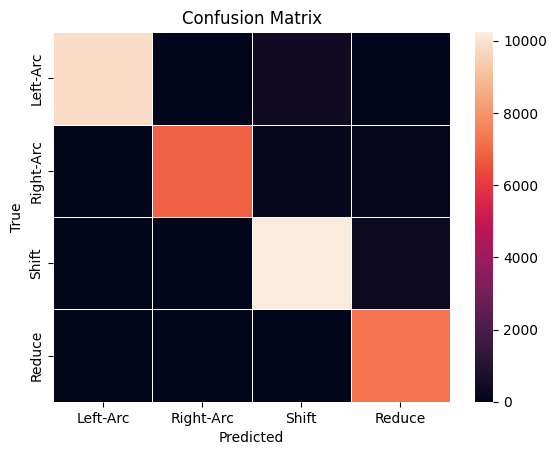

In [40]:
labels = ['Left-Arc', 'Right-Arc', 'Shift', 'Reduce']

# Create the heatmap plot
ax = sns.heatmap(confusion_array, linewidth=0.5)

# Set the x and y tick labels
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
# Set the title
ax.set_title('Confusion Matrix')

# Display the plot
plt.show()

In [41]:
from tabulate import tabulate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class_accuracy = confusion_array.diagonal() / confusion_array.sum(axis=1)
num_classes = confusion_array.shape[0]
true_positives = confusion_array.diagonal()
predicted_positives = confusion_array.sum(axis=0)
actual_positives = confusion_array.sum(axis=1)

precision = true_positives / predicted_positives
recall = true_positives / actual_positives

f1_scores = 2 * (precision * recall) / (precision + recall)
global_f1 = sum(f1_scores) / num_classes

table_data = []
for i, class_acc in enumerate(class_accuracy):
    if i == 0:
      table_data.append(["Left-Arc",class_acc])
    elif i == 1:
      table_data.append(["Right-Arc", class_acc])
    elif i == 2:
      table_data.append(["Shift", class_acc])
    elif i == 3:
      table_data.append(["Reduce", class_acc])

table_data.append(["Global F1", global_f1])
table_headers = ["Actions", "Accuracy"]
print(tabulate(table_data, headers=table_headers))

Actions      Accuracy
---------  ----------
Left-Arc     0.958561
Right-Arc    0.945399
Shift        0.966481
Reduce       1
Global F1    0.967204


Looking at the matrix reveals that reduce moves are consistently executed correctly, whereas shifts are commonly favored over right/left arcs. The action that causes the most confusion overall is the right arc.

## Discussion

Numerous combinations were tried (1/2 layers, 16/24/32 batches, 200/300 dim. word embedding, 200/300 dim. LSTM); the UAS on validation varied by little ($\approx 0.1$), but what was noticeable was that some combinations were able to converge using less epochs. The **LSTM model** used as baseline has been adapted to have an architecture that is similar to the ones that are currently in the leaderboards of the SoTA.
The **baseline UAS** determined through testing using the ideal set of parameters was $0.696$.

The final UAS score for the BERT model was $0.819$; phrase embeddings were created by adding the last four hidden layers, as described in the lectures and in numerous articles; and the best parameters were determined using validation data and a small training set.

The **current SoTA** has an UAS of $\approx 0.90$.  
Results of the SoTA were found on:
* https://arxiv.org/pdf/1908.07448.pdf
* Straka, Milan & Strakova, Jana & Hajič, Jan. (2019). Evaluating Contextualized Embeddings on 54 Languages in POS Tagging, Lemmatization and Dependency Parsing.

